In [2]:
library(arrow)
library(tidyverse)

In [6]:
# read country latitude data
pop <- read_parquet("../data/processed_data/populated.parquet")
poplat <- pop %>%
	group_by(adm0name) %>%
	mutate(pop = case_when(pop==0 ~ 1, TRUE ~ pop)) %>%
	summarise(lat = mean(lat * pop, na.rm=T) / sum(pop, na.rm=T))
head(poplat)

adm0name,lat
<chr>,<dbl>
Afghanistan,1.0451242
Aland,60.0969962
Albania,1.5845929
Algeria,0.6904075
American Samoa,-14.2766105
Andorra,42.5000014


In [8]:
# read utci
utci <- read_parquet("../data/processed_data/utci_country_monthly.parquet") %>%
	as_tibble() %>%
	select(-c("__index_level_0__")) %>%
	mutate(month=as.numeric(month)) %>% 
	inner_join(poplat) %>% 
	group_by(adm0name) %>%
	do({
		x <- .
		x$hemisphere <- "Northern"
		if(x$lat[1] < 0)
		{
			x$month <- x$month + 6
			x$month[x$month > 12] <- x$month[x$month > 12] - 12
			x$hemisphere <- "Southern"
		}
		x
	})
head(utci)

Joining, by = "adm0name"



year,month,adm0name,model,scenario,quantile,utci,lat,hemisphere
<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1985,1,Afghanistan,HadGEM3-GC31-LL,historical,95pc,286.4534,1.045124,Northern
1985,2,Afghanistan,HadGEM3-GC31-LL,historical,95pc,289.3621,1.045124,Northern
1985,3,Afghanistan,HadGEM3-GC31-LL,historical,95pc,297.5734,1.045124,Northern
1985,4,Afghanistan,HadGEM3-GC31-LL,historical,95pc,299.3901,1.045124,Northern
1985,5,Afghanistan,HadGEM3-GC31-LL,historical,95pc,307.4036,1.045124,Northern
1985,6,Afghanistan,HadGEM3-GC31-LL,historical,95pc,307.2870,1.045124,Northern


In [9]:
# Read mortality data
mort <- read_parquet("../data/processed_data/un_mortality.parquet") %>%
	as_tibble() %>%
	select(-c("__index_level_0__")) %>%
	mutate(Year=as.numeric(Year), month=as.numeric(month)) %>% 
	inner_join(poplat, by=c("Country or Area"="adm0name")) %>% 
	group_by(`Country or Area`) %>%
	do({
		x <- .
		x$hemisphere <- "Northern"
		if(x$lat[1] < 0)
		{
			x$month <- x$month + 6
			x$month[x$month > 12] <- x$month[x$month > 12] - 12
			x$hemisphere <- "Southern"
		}
		x
	})
head(mort)

Country or Area,Year,Area,Month,Record Type,Reliability,Source Year,Value,Value Footnotes,month,lat,hemisphere
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
Albania,2018,Total,January,Data tabulated by year of occurrence,"Final figure, complete",2020,2158,NA,1,1.584593,Northern
Albania,2018,Total,February,Data tabulated by year of occurrence,"Final figure, complete",2020,2013,NA,2,1.584593,Northern
Albania,2018,Total,March,Data tabulated by year of occurrence,"Final figure, complete",2020,2136,NA,3,1.584593,Northern
Albania,2018,Total,April,Data tabulated by year of occurrence,"Final figure, complete",2020,1828,NA,4,1.584593,Northern
Albania,2018,Total,May,Data tabulated by year of occurrence,"Final figure, complete",2020,1664,NA,5,1.584593,Northern
Albania,2018,Total,June,Data tabulated by year of occurrence,"Final figure, complete",2020,1576,NA,6,1.584593,Northern


In [10]:
# merge
dat <- inner_join(utci, mort, by=c("adm0name"="Country or Area", "year"="Year", "month"="month"))
str(dat)

grouped_df[,18] [142,502 × 18] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ year           : num [1:142502] 1985 1985 1985 1985 1985 ...
 $ month          : num [1:142502] 1 2 3 4 5 6 7 8 9 10 ...
 $ adm0name       : chr [1:142502] "Albania" "Albania" "Albania" "Albania" ...
 $ model          : chr [1:142502] "HadGEM3-GC31-LL" "HadGEM3-GC31-LL" "HadGEM3-GC31-LL" "HadGEM3-GC31-LL" ...
 $ scenario       : chr [1:142502] "historical" "historical" "historical" "historical" ...
 $ quantile       : chr [1:142502] "95pc" "95pc" "95pc" "95pc" ...
 $ utci           : num [1:142502] 287 291 292 298 305 ...
 $ lat.x          : num [1:142502] 1.58 1.58 1.58 1.58 1.58 ...
 $ hemisphere.x   : chr [1:142502] "Northern" "Northern" "Northern" "Northern" ...
 $ Area           : chr [1:142502] "Total" "Total" "Total" "Total" ...
 $ Month          : chr [1:142502] "January" "February" "March" "April" ...
 $ Record Type    : chr [1:142502] "Data tabulated by year of occurrence" "Data tabulated by year of occu

In [11]:
# model mortality and utci
utci_mortality_model <- function(utci, dat, climatemodel, country, months = 1:12)
{
	out <- list()
	traindat <- subset(dat, adm0name %in% country & model %in% climatemodel & scenario == "historical" & quantile == "avg" & month %in% months)
	mod <- lm(Value ~ utci + I(utci^2) + I(utci^3), data=traindat)
	
	p <- predict(mod, traindat, interval='confidence', level=0.975)
	traindat$pred <- p[,1]
	traindat$predl <- p[,2]
	traindat$predu <- p[,3]
	pl1 <- ggplot(traindat, aes(x=utci, y=Value)) +
		geom_point() +
		geom_smooth(method="lm") +
		geom_line(data=traindat, aes(x=utci, y=pred)) +
		geom_line(data=traindat, aes(x=utci, y=predl), linetype="dotted") +
		geom_line(data=traindat, aes(x=utci, y=predu), linetype="dotted")

	spd <- subset(utci, adm0name == country & model == climatemodel & scenario != "historical" & quantile == "avg" & month %in% months)

	spd$mortpred <- predict(mod, spd)

	spds <- group_by(spd, adm0name, year, model, scenario, quantile) %>%
		summarise(mortpred=sum(mortpred), n=n()) %>%
		filter(n == length(months))

	pl2 <- ggplot(spds, aes(x=year, y=mortpred)) +
			geom_point(aes(colour=scenario)) +
			geom_smooth(aes(colour=scenario)) +
			scale_colour_brewer(type="qual")

	out$mod <- summary(mod)
	out$pl1 <- pl1
	out$spds <- spds
	out$pl2 <- pl2

	if(all(1:12 %in% months))
	{
		spdsplit <- group_by(spd, adm0name, year, model, scenario, quantile, summer=month %in% 5:10) %>%
			summarise(mortpred=sum(mortpred), n=n()) %>%
			filter(n == 6) %>%
			mutate(summer = case_when(!summer ~ "winter", summer ~ "summer"))

		pl3 <- ggplot(spdsplit, aes(x=year, y=mortpred)) +
			geom_point(aes(colour=scenario)) +
			geom_smooth(aes(colour=scenario)) +
			facet_grid(. ~ summer) +
			scale_colour_brewer(type="qual")

		out$spdsplit <- spdsplit
		out$pl3 <- pl3
	}
	return(out)
}


In [16]:
# Spain example
o <- utci_mortality_model(utci, dat, "HadGEM3-GC31-LL", "Spain")

`summarise()` has grouped output by 'adm0name', 'year', 'model', 'scenario'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'adm0name', 'year', 'model', 'scenario', 'quantile'. You can override using the `.groups` argument.



`geom_smooth()` using formula 'y ~ x'



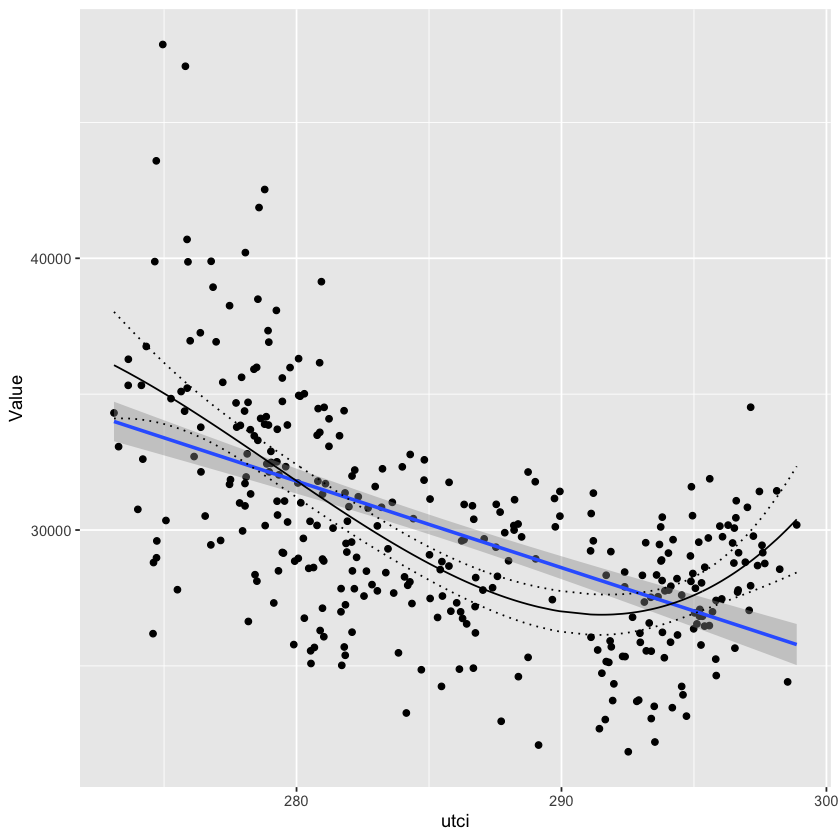

In [17]:
# training data
o$pl1

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



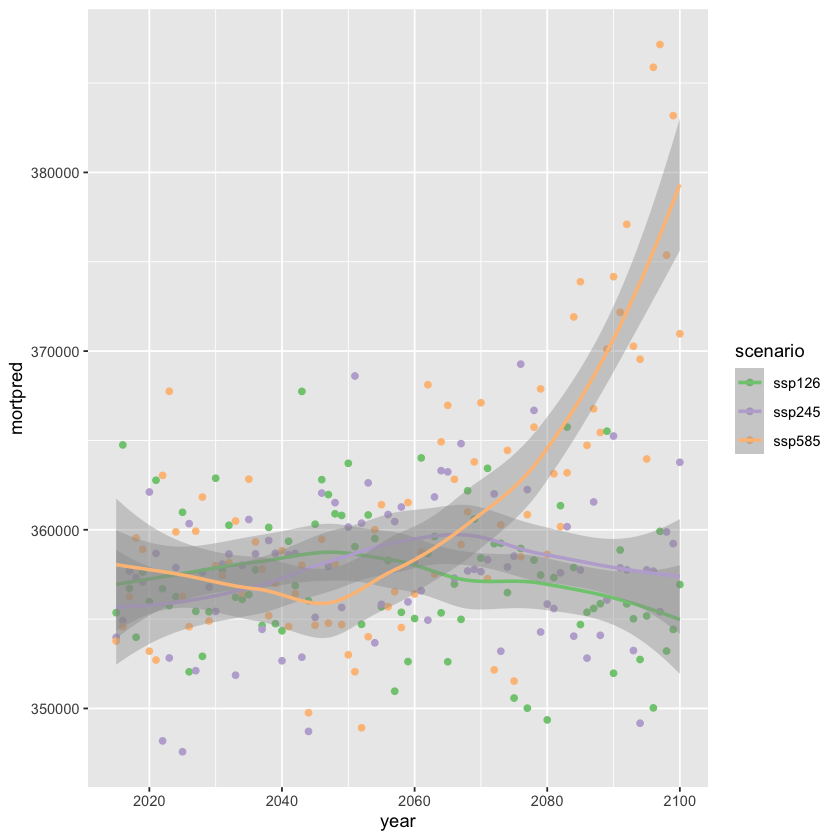

In [18]:
# projection for all months
o$pl2

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



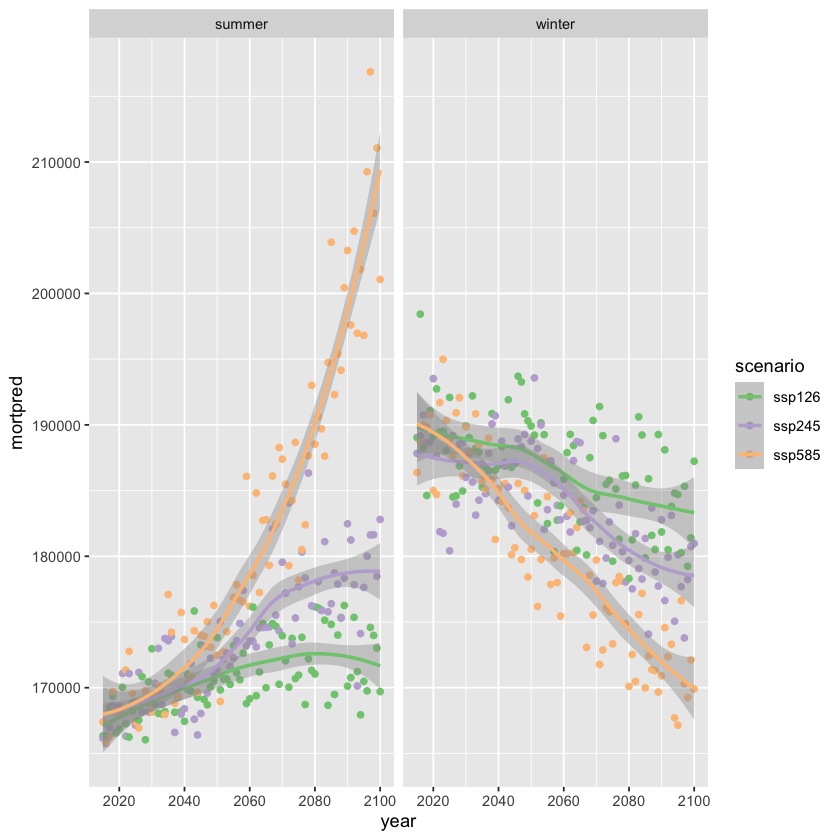

In [20]:
# projection stratified by winter/summer
o$pl3

In [23]:
# Do it for all countries and models
p <- expand.grid(model=unique(dat$model), country=unique(dat$adm0name))
res <- lapply(1:nrow(p), function(i)
{
	o <- tryCatch(suppressMessages(utci_mortality_model(utci, dat, p$model[i], p$country[i])$spdsplit), error=function(cond) {return(NULL)})
	return(o)

}) %>% bind_rows()

ress <- res %>%
	group_by(year, model, scenario, quantile, summer) %>%
	summarise(mortpred = sum(mortpred))

Warning message in predict.lm(mod, traindat, interval = "confidence", level = 0.975):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, spd):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, traindat, interval = "confidence", level = 0.975):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, spd):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, traindat, interval = "confidence", level = 0.975):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, spd):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, traindat, interval = "confidence", level = 0.975):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, spd):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(mod, t

In [24]:
ress

year,model,scenario,quantile,summer,mortpred
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
2015,BCC-CSM2-MR,ssp126,avg,summer,6658277
2015,BCC-CSM2-MR,ssp126,avg,winter,7249663
2015,BCC-CSM2-MR,ssp245,avg,summer,6658492
2015,BCC-CSM2-MR,ssp245,avg,winter,7212983
2015,BCC-CSM2-MR,ssp585,avg,summer,6662661
2015,BCC-CSM2-MR,ssp585,avg,winter,7217030
2015,CMCC-ESM2,ssp126,avg,summer,6660902
2015,CMCC-ESM2,ssp126,avg,winter,7237292
2015,CMCC-ESM2,ssp245,avg,summer,6646588


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



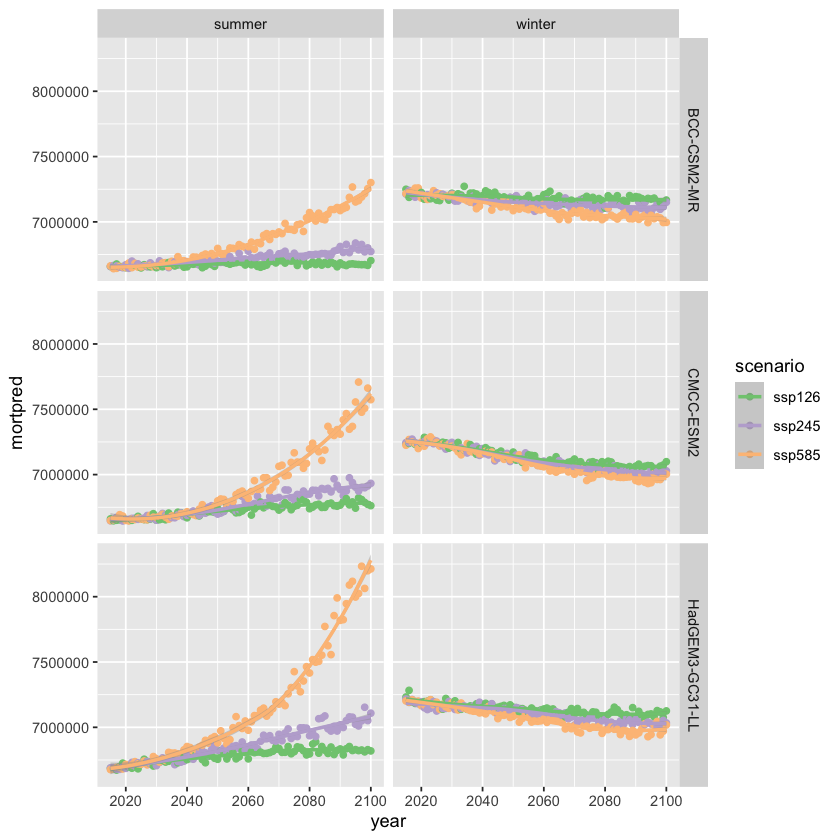

In [25]:
ggplot(ress, aes(x=year, y=mortpred)) +
geom_point(aes(colour=scenario)) +
geom_smooth(aes(colour=scenario)) +
facet_grid(model ~ summer) +
scale_colour_brewer(type="qual")


In [26]:
ggsave(file="../results/mortality_prediction.pdf")

Saving 7 x 7 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



In [27]:
write_parquet(res, "../data/processed_data/mortality_prediction.parquet", compression="gzip")